## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
# import gdown
from zipfile import ZipFile

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "../input/64poket",  label_mode=None, image_size=(64, 64), batch_size=32, 
)
dataset = dataset.map(lambda x: x / 255.0)


Found 14774 files belonging to 1 classes.


Let's display a sample image:

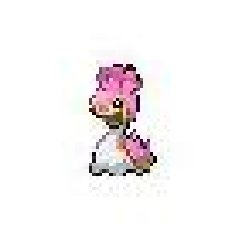

In [3]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

## Override `train_step`

In [6]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        # generate 1, real 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        # 모두 “진짜 이미지"라고 레이블을 만듭니다 (사실은 거짓)
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator 
        # (note that we should *not* update the weights of the discriminator)!
        # (gan 모델에서 discriminator의 가중치는 동결됩니다)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [7]:
# fit()의 callbacks를 통해 학습 과정 중 콜백을 사용해서 모델의 내적 상태 모니터링

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        # 생성된 이미지 저장
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Train the end-to-end model

In [9]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/100
462/462 [==============================] - 78s 168ms/step - d_loss: 0.6022 - g_loss: 1.3398
Epoch 2/100
462/462 [==============================] - 78s 169ms/step - d_loss: 0.5229 - g_loss: 1.6532
Epoch 3/100
462/462 [==============================] - 76s 165ms/step - d_loss: 0.5823 - g_loss: 1.5097
Epoch 4/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.3585 - g_loss: 3.5645
Epoch 5/100
462/462 [==============================] - 74s 161ms/step - d_loss: 0.3155 - g_loss: 3.1117
Epoch 6/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.3890 - g_loss: 2.1560
Epoch 7/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.4419 - g_loss: 2.1371
Epoch 8/100
462/462 [==============================] - 74s 159ms/step - d_loss: 0.5184 - g_loss: 1.6061
Epoch 9/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.4804 - g_loss: 1.6319
Epoch 10/100
462/462 [==============================] - 74s 160m

462/462 [==============================] - 74s 160ms/step - d_loss: 0.2949 - g_loss: 2.4030
Epoch 80/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.2550 - g_loss: 2.4840
Epoch 81/100
462/462 [==============================] - 75s 163ms/step - d_loss: 0.2776 - g_loss: 2.7067
Epoch 82/100
462/462 [==============================] - 79s 172ms/step - d_loss: 0.2620 - g_loss: 2.5794
Epoch 83/100
462/462 [==============================] - 75s 161ms/step - d_loss: 0.2520 - g_loss: 2.5832
Epoch 84/100
462/462 [==============================] - 76s 164ms/step - d_loss: 0.2763 - g_loss: 2.4743
Epoch 85/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.2257 - g_loss: 2.8833
Epoch 86/100
462/462 [==============================] - 74s 160ms/step - d_loss: 0.2290 - g_loss: 2.8146
Epoch 87/100
462/462 [==============================] - 74s 159ms/step - d_loss: 0.2036 - g_loss: 3.0434
Epoch 88/100
462/462 [==============================] - 74s 160ms/st

In [12]:
def gen(): 
    import tensorflow as tf 
    import matplotlib.pyplot as plt 
    import numpy 
    
    v = tf.random.normal([1, latent_dim]) 
    x = generator.predict(v) 
    x = x.reshape(64, 64, 3) 
    plt.imshow(x) 
    
    return x

array([[[1.        , 1.        , 0.9999999 ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

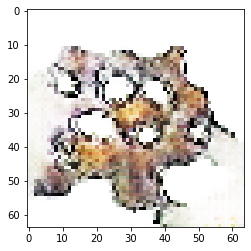

In [14]:
gen()

In [15]:
!pip install tensorflowjs


     |████████████████████████████████| 63 kB 867 kB/s eta 0:00:011


     |████████████████████████████████| 103 kB 4.0 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [16]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(generator, './model')
